# Comparative Analysis of Chemical Composition in Red and White Wines: A Study of Volatile Acidity

<b> Group 18 Members: </b> Vivaan Wadhwa(88889191), Katie Archer (84677194), Katelyn Thomas (40530578), Justin Lieu (15032485)

In [1]:
# Required libraries
library(tidyverse)
install.packages("infer")
library(infer)
library(repr)
library(dplyr)
library(readr)
options(repr.plot.width=8, repr.plot.height=8)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
# Reading in the data
url <- "https://archive.ics.uci.edu/static/public/186/wine+quality.zip"

# Define the local file name for the downloaded ZIP file
zip_file <- "data/wine_quality.zip"

# Download the ZIP file from the URL
download.file(url, destfile = zip_file)

# Unzip the downloaded file
unzip(zip_file, exdir = "data")

## Introduction

The goal of the project is to explore the average level of Volatile Acidity in Red and White wine. The dataset, [Wine Quality](https://archive.ics.uci.edu/dataset/186/wine+quality), is taken from [UCI Machine Learning Repository](https://archive.ics.uci.edu/datasets).

The dataset includes 13 attributes describing 

- ```Fixed Acidity```
- ```Volatile Acidity```
- ```Citric Acid```
- ```Residual Sugar```
- ```Chlorides```
- ```Free Sulfur Dioxide```
- ```Total Sulfur Dioxide```
- ```Density```
- ```pH```
- ```sulphates```
- ```alcohol```
- ```quality```

### Research Question

How do the levels of <b>volatile acidity</b> differ between <b>red</b> and <b>white wines</b>, and are there statistically significant variations in this chemical component between the two wine types?

Our attribute of interest for this project is:

- ```Volatile Acidity```: Volatile acidity in the context of wine refers to the presence of volatile acids, primarily acetic acid.  It is a key factor in wine quality and can impact the wine's flavor and aroma.

To conduct research, we will be exploring the average levels (location parameter) of <b>volatile acidity</b> for each of the wines as well as standard deviation (scale parameter).                 



<b> Are we doing standard deviation??
Also, do we have more details on the population? </b>

Volatile acidity plays a pivotal role in the winemaking process, and exhibits substantial variations across different wines. A study conducted by Babincev and Jović in 2021 delves into the chemical composition of white and red wines, revealing that red wine tends to have higher acidity levels compared to white wine. This finding underscores the importance and relevance of further investigation of volatile acidity.

## Exploratory Data Analysis

### Wrangling the data

First, we read in the red wine and white wine data and check to see if there are any missing values. We also add a column to 
each dataset to indicate the type of wine. Seeing that there are no missing values, there is no need to remove any rows and we proceed by combining the data into one data frame.

In [3]:
# Read in the red and white wine data

wine_red_data <- read_delim("data/winequality-red.csv", delim = ";", show_col_types = FALSE) |>
                    mutate(type = "red")
wine_white_data <- read_delim("data/winequality-white.csv", delim = ";", show_col_types = FALSE)|>
                    mutate(type = "white")
# Check if we have missing values
sum(is.na(wine_white_data))
sum(is.na(wine_red_data)) 

[1] 0

[1] 0

In [4]:
# Combining the red/white wine data and adding proper column names to the dataframe

wine_data <- rbind(wine_red_data, wine_white_data)
colnames(wine_data) <- c("fixed.acidity","volatile.acidity","citric.acid","residual.sugar",
                         "chlorides","free.sulfur.dioxide","total.sulfur.dioxide","density",
                         "pH","sulphates","alcohol","quality","type")
head(wine_data)

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,type
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,red
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5,red
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5,red
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6,red
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,red
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5,red


Now that we have combined the two datasets, we drop all the unnecessary columns to isolate our attribute of focus (volatile acidity) and the wine type.

In [5]:
wine_data_specific <- wine_data %>%
                        select(volatile.acidity, type)
head(wine_data_specific)

volatile.acidity,type
<dbl>,<chr>
0.70,red
0.88,red
0.76,red
0.28,red
0.70,red
0.66,red


In [6]:
dim(wine_data_specific)

[1] 6497    2

# Preliminary Analysis #

We begin by conducting some preliminary analysis to explore our data. Here we plot the sample distribution for our attribute of interest, volatile acidity, using colour to differentiate between the red and white wine observations.

#### Figure 1: Histogram of volatile acidity (red vs. white)

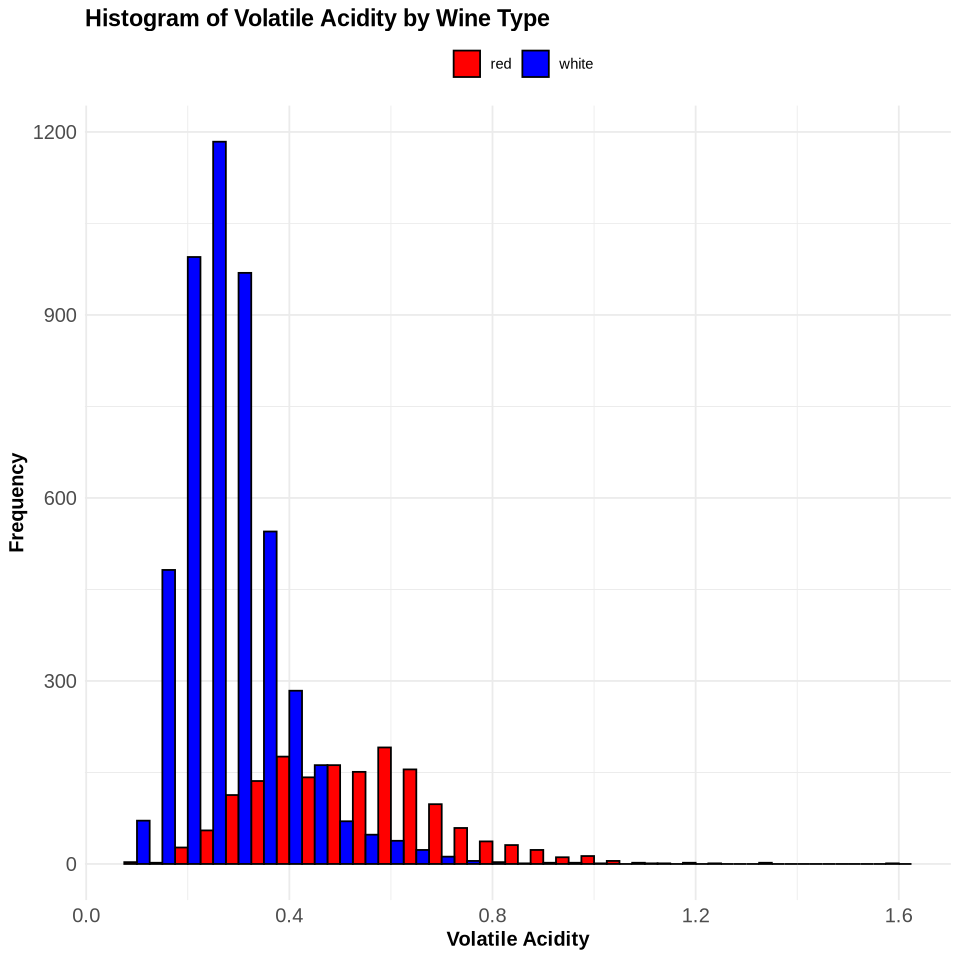

In [7]:
# Histogram of volatile acidity against the respective wine type

ggplot(wine_data_specific, aes(x = volatile.acidity, fill = type)) +
  geom_histogram(binwidth = 0.05, position = "dodge", color = "black") +
  labs(title = paste("Histogram of Volatile Acidity by Wine Type"), x = "Volatile Acidity", y = "Frequency") +
  scale_fill_manual(values = c("red" = "red", "white" = "blue")) +
  theme_minimal() +
  theme(legend.title = element_blank(),
        legend.position = "top",  # Change the legend position
        plot.title = element_text(size = 14, face = "bold"),  # Title style
        axis.text = element_text(size = 12),  # Axis label text size
        axis.title = element_text(size = 12, face = "bold")) 

The histogram clearly illustrates a contrast in the mean concentration of volatile acids between red and white wines in our sample. White wine appears to have a much lower mean concentration than red wine, hence the value of conducting a hypothesis test. 

We also produce a boxplot to more easily see the difference in distribution of volatile acid concentration between the 2 wine types. As can be seen below, each type of wine exhibits a unique distribution pattern, emphasizing the disparity observed in their chemical composition.

#### Figure 2: Side-by-side boxplots of volatile acidity (red vs. white)

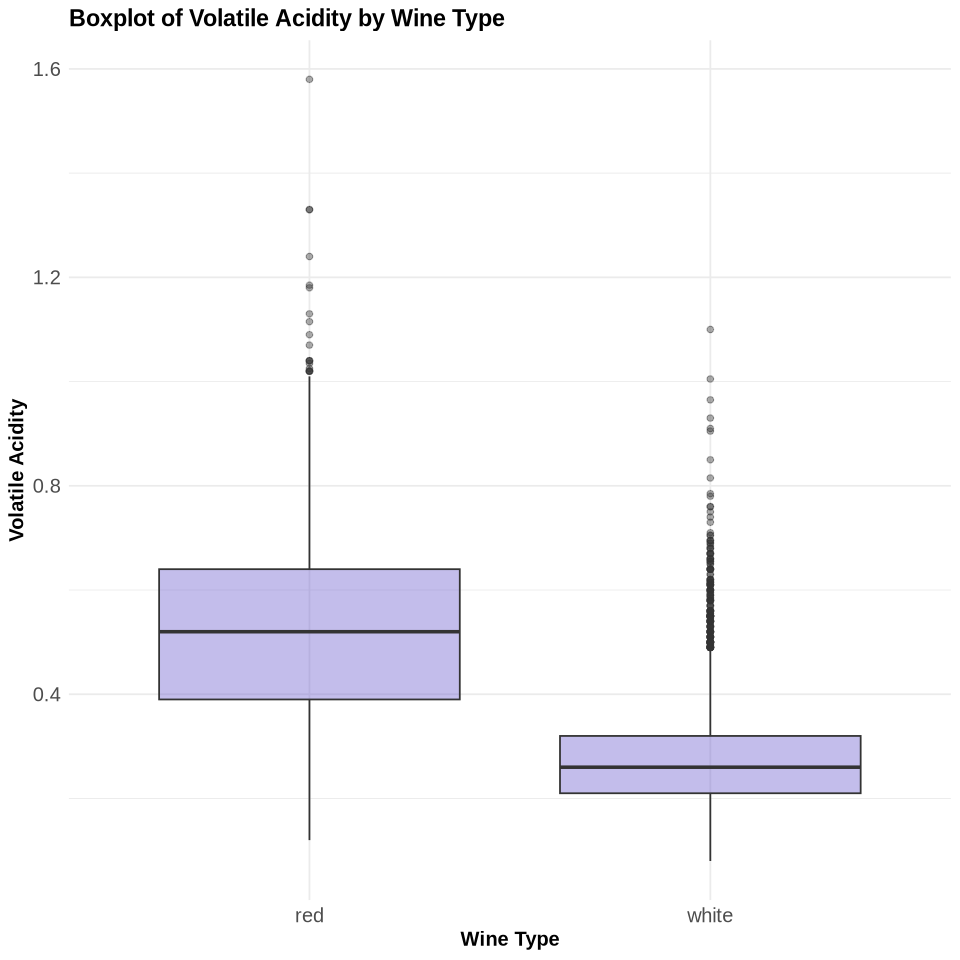

In [8]:
ggplot(wine_data_specific, aes(x = type, y = volatile.acidity)) +
      geom_boxplot(fill = "slateblue", alpha = 0.4) +
      labs(title = paste("Boxplot of Volatile Acidity by Wine Type", sep = " "), x = "Wine Type", y = "Volatile Acidity") +
      theme_minimal() +
      theme(legend.title = element_blank(),
            legend.position = "top",  # Change the legend position
            plot.title = element_text(size = 14, face = "bold"),  # Title style
            axis.text = element_text(size = 12),  # Axis label text size
            axis.title = element_text(size = 12, face = "bold"))

# Methods and Results

## Overview

We will be conducting a hypothesis test at the 5% significance level via permutation, in order to examine the difference in mean volatile acidity between red and white wine. Our null hypothesis is

$$H_{0}: \mu_{\text{Volatile Acidity of Red Wine}} - \mu_{\text{Volatile Acidity of White Wine}} = 0$$ 

and our alternative hypothesis is 

$$H_{a}: \mu_{\text{Volatile Acidity of Red Wine}} - \mu_{\text{Volatile Acidity of White Wine}} \neq 0$$

We will also be creating a 95% confidence interval using CLT, in order to propose a plausible range of values for the true difference in mean volatile acididty across the 2 types of wine, and also take a look at the variance of each variable.

### Central Limit Theorem

- <b>Random</b>: The sampling must be done at random.
- <b>Independence of Sample</b>: Each observation in the sample must be unrelated to one another.
- <b>Sample Size</b>: The sample size should not exceed 10% of the total population.

As the conditions mandated by the Central Limit Theorem have been satisfied, it is reasonable to proceed with the assumption of normality for statistical analyses.

## Asymptotic Method

Given that our sample meets the conditions set by the Central Limit Theorem (CLT), allowing us to confidently apply theoretical inference techniques, we opt for a 2-sample t-test. In this scenario, the population standard deviation remains unknown to us. Therefore, our test statistic is computed as:

$$\normalsize t = \frac{(\bar{x}_1 - \bar{x}_2)}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}$$

In [9]:
red_wine <- wine_data_specific |>
            filter(type == "red")

white_wine <- wine_data_specific |>
            filter(type == "white")

x_bar_1 <- mean(red_wine$volatile.acidity)
x_bar_2 <- mean(white_wine$volatile.acidity)

red_wine_sd <- sd(red_wine$volatile.acidity)
white_wine_sd <- sd(white_wine$volatile.acidity)
n1 <- nrow(red_wine)
n2<- nrow(white_wine)

pooled_sample_sd <- sqrt((red_wine_sd^2 / n1) + (white_wine_sd^2 / n2))

test_statistic <- (x_bar_1 - x_bar_2)/pooled_sample_sd
test_statistic

[1] 53.05909

We can calculate the degrees of freedom for the same using the following formula:

$$\normalsize v = \frac{{\left(\frac{{s_1^2}}{{n_1}} + \frac{{s_2^2}}{{n_2}}\right)^2}}{{\frac{{s_1^4}}{{n_1^2 \cdot (n_1 - 1)}} + \frac{{s_2^4}}{{n_2^2 \cdot (n_2 - 1)}}}}
$$



In [10]:
degrees_freedom <- (red_wine_sd^2 / n1 + white_wine_sd^2 / n2)^2 /
                    ((red_wine_sd^2)^2 / (n1^2 * (n1 - 1)) + (white_wine_sd^2)^2 / (n2^2 * (n2 - 1)))

degrees_freedom

[1] 1938.938

In [11]:
# Calculate p-value using pt() for a two-tailed test
p_value <- 2 * pt(abs(test_statistic), df = degrees_freedom, lower.tail = FALSE)

# Check if p-value is extremely small
if (p_value < 0.001) {
  p_value <- "< 0.001"
}

p_value

[1] "< 0.001"

Since our p value is falls below our significance level, we reject null hypothesis by the asymtotic method.

## Null Distribution and Confidence Interval via Bootstrapping

#### Null Distribution for Difference in Means

In [12]:
null_dist <- wine_data_specific %>%
    specify(volatile.acidity ~ type) %>%
    hypothesize(null = "independence") %>%
    generate(reps = 1000, type="permute") %>%
    calculate(stat = "diff in means", order = c("red", "white"))
head(null_dist)

replicate,stat
<int>,<dbl>
1,-0.002103698
2,-0.007267684
3,0.003906434
4,-0.004957371
5,-0.001307325
6,0.003918877


#### CI for Difference in Means

In [13]:
# Confidence Interval
confidence_interval <- wine_data_specific |>
                           specify(volatile.acidity ~ type) %>%
                            generate(reps=1000, type='bootstrap')|>
                            calculate(stat='diff in means', order = c("red", "white")) |>
                            get_ci()
confidence_interval

lower_ci,upper_ci
<dbl>,<dbl>
0.2405356,0.2592272


#### Finding the observed difference in means

In [14]:
obs_diff_in_means <- wine_data_specific %>%
    specify(volatile.acidity ~ type) %>%
    calculate(stat = "diff in means", order = c("red", "white"))

obs_diff_in_means

stat
<dbl>
0.2495794


#### Figure 3: Simulation-Based Null Distribution Plot for Diff in Means

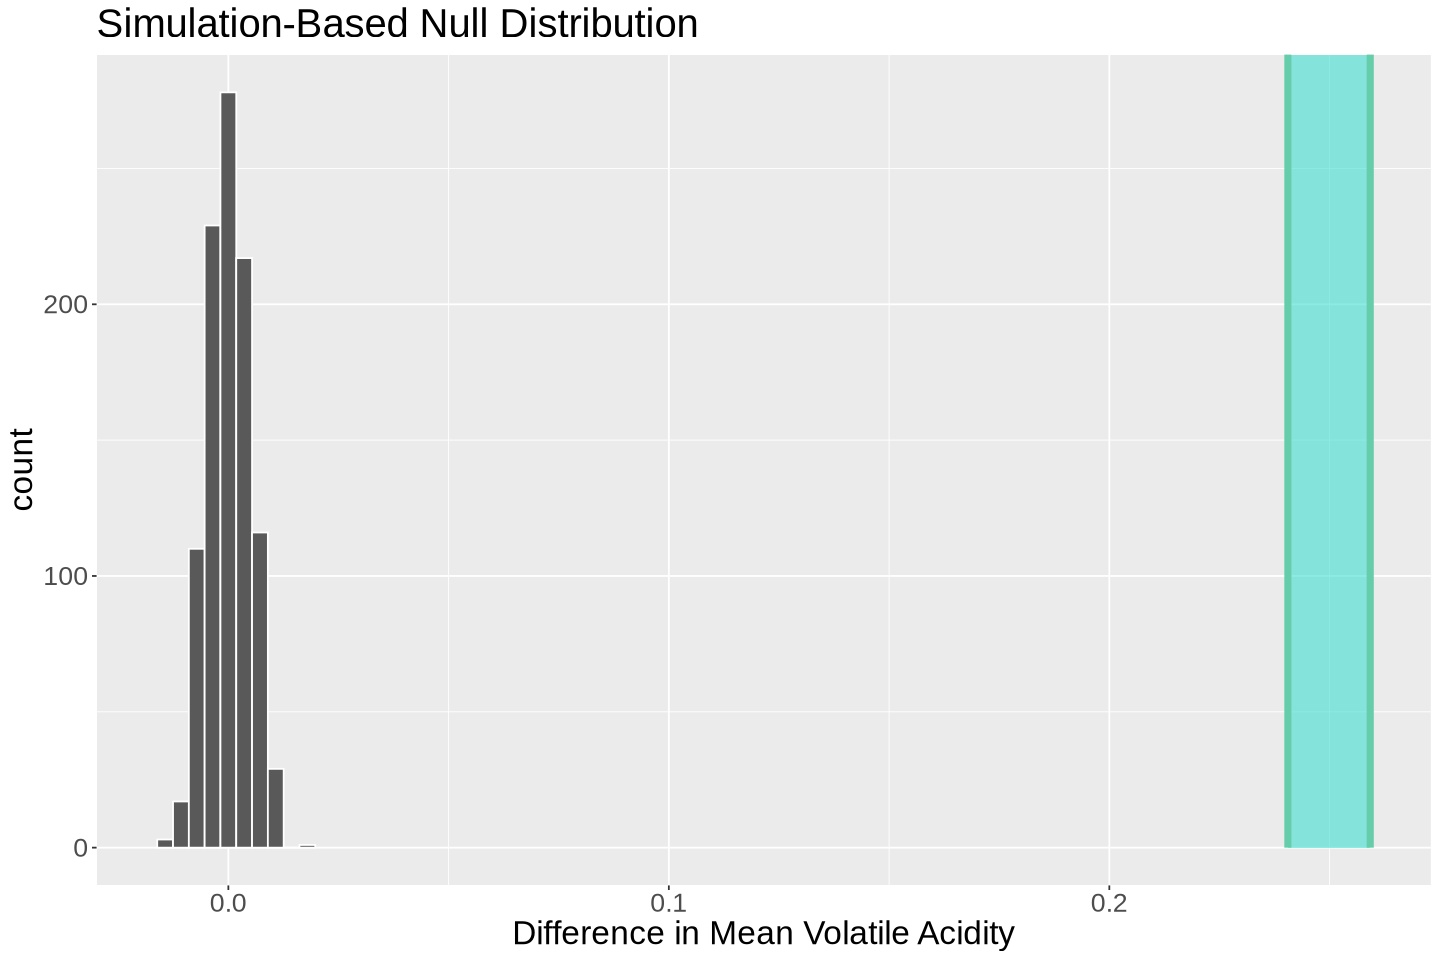

In [15]:
options(repr.plot.width=12, repr.plot.height=8)
visualize(null_dist, bins = 10) + 
    shade_ci(endpoints = confidence_interval) +
    theme(
    plot.title = element_text(size = 24), 
    axis.title.x = element_text(size = 20),  
    axis.title.y = element_text(size = 20),  
    axis.text.x = element_text(size = 16), 
    axis.text.y = element_text(size = 16)) +
    xlab("Difference in Mean Volatile Acidity")

In [16]:
result <- suppressWarnings({
  p_val <- null_dist %>%
    get_p_value(obs_stat = obs_diff_in_means, direction = "two-sided")
  p_val
})

if (result == 0) {
  result <- "< 0.001"
}

print(result)

[1] "< 0.001"


## Exploring Difference in Variance via Bootstrapping

In [17]:
set.seed(1234) #do not change

wine_white_resample_var <- wine_data_specific %>%
                    filter(type == "white")%>%
                    specify(response=volatile.acidity)%>%
                    generate(reps=1000, type = "bootstrap")%>%
                    calculate(stat="sd")%>%
                    mutate(stat = stat)

wine_diff_var <- wine_data_specific %>%
                    filter(type == "red")%>%
                    specify(response=volatile.acidity)%>%
                    generate(reps=1000, type = "bootstrap")%>%
                    calculate(stat="sd")%>%
                    mutate(stat = stat^2 - wine_white_resample_var$stat)

print(nrow(wine_diff_var))
head(wine_diff_var)

[1] 1000


replicate,stat
<int>,<dbl>
1,-0.06806641
2,-0.06746829
3,-0.06823174
4,-0.06876941
5,-0.06859993
6,-0.07071506


#### Calculating the Observed Difference in Variance

In [18]:
red_wine <- wine_data_specific |>
            filter(type == "red")

white_wine <- wine_data_specific |>
            filter(type == "white")

observed_diff_var <- sd(red_wine$volatile.acidity)^2 - sd(white_wine$volatile.acidity)^2
observed_diff_var

[1] 0.02190284

#### Finding the CI for Variance

In [19]:
wine_var_ci <- wine_diff_var %>% 
            get_confidence_interval(level = 0.95, type = "percentile")
wine_var_ci

lower_ci,upper_ci
<dbl>,<dbl>
-0.07334606,-0.06399106


#### Creating a Null Model for Variance

In [20]:
null_model <- wine_diff_var |>
            mutate(stat = stat - observed_diff_var)
head(null_model)

replicate,stat
<int>,<dbl>
1,-0.08996925
2,-0.08937113
3,-0.09013457
4,-0.09067225
5,-0.09050277
6,-0.09261790


#### Figure 4: Simulation-Based Bootstrap Distribution of Diff in Variance

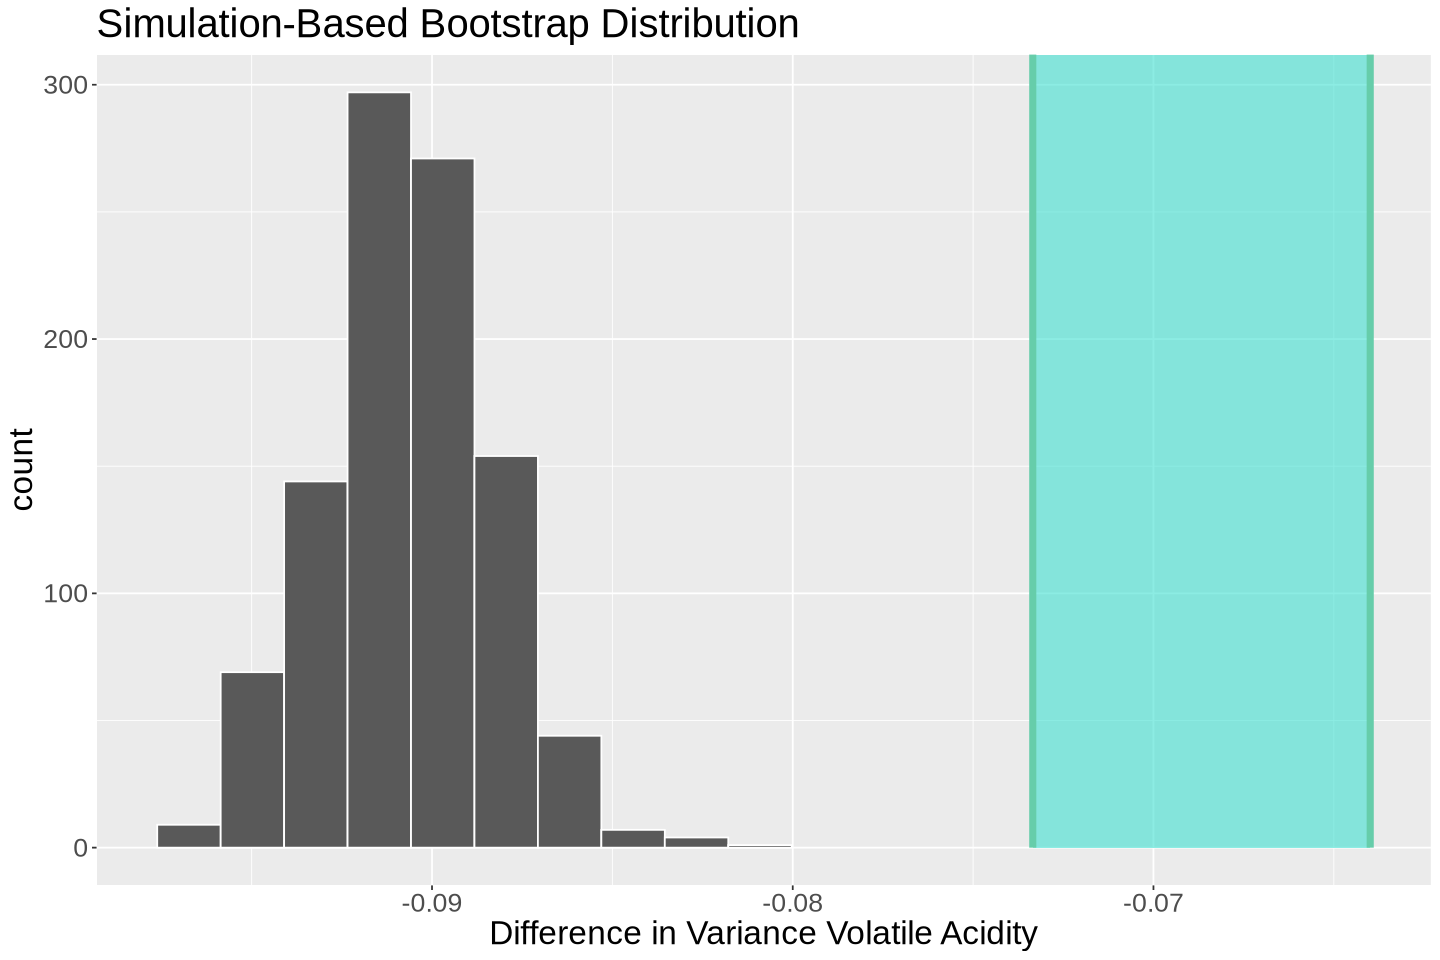

In [21]:
options(repr.plot.width=12, repr.plot.height=8)
visualize(null_model, bins = 10) + 
    shade_ci(endpoints = wine_var_ci) +
    theme(
    plot.title = element_text(size = 24), 
    axis.title.x = element_text(size = 20),  
    axis.title.y = element_text(size = 20),  
    axis.text.x = element_text(size = 16), 
    axis.text.y = element_text(size = 16)) +
    xlab("Difference in Variance Volatile Acidity")

In [22]:
result <- suppressWarnings({
  p_val <- null_dist %>%
    get_p_value(obs_stat = observed_diff_var, direction = "two-sided")
  p_val
})

if (result == 0) {
  result <- "< 0.001"
}

print(result)

[1] "< 0.001"


## Discussion

### Findings

Examining the null distribution under the hypothesis of no difference in mean volatile acidity between red and white wine, we find compelling evidence to reject the null hypothesis (H0). Our null hypothesis, asserting 
$H_{0}: \mu_{\text{Volatile Acidity of Red Wine}} - \mu_{\text{Volatile Acidity of White Wine}} = 0$, is not supported by our analysis. The calculated p-value is significantly less than 0, indicating that the probability of obtaining such extreme results by chance alone under the assumption of the null hypothesis is essentially negligible. Both of our calculated confidence intervals also coincide with our conclusion. Therefore, we can conclude from our test that we reject the null hypothesis, and that there is a significant difference in volatile acidity between red and white wine with a 95% level of confidence.

### Limitations/Drawbacks

- Our knowledge of volatile acidity and winemaking prior to the analysis was limited, so choosing a null hypothesis setting our mean difference equal to 0 was a trivial decision.
- It is possible that there are other wines out there that are more heavily weighted as the wine industry is always changing. As a result, our sample may fail to be fully representative of those changes.
- Our analysis is based on the assumption that volatile acidity is not affected by other factors (i.e. we only examined the difference between red and white wine, but there could be differences between other types of red/white wine like cabernet, merlot, pinot noir, etc.)

### Future Ideas/Questions

- What other specific factors contribute to the observed difference in volatile acidity in red wines vs. white wines?
- How does the difference in volatile acidity translate to variation in the taste of red wine and white wine?
- What is the impact of aging wine on volatile acidity?
- Are there certain patterns that can be derived on what consumers deem to be the best level of volatile acidity?

## References

- Babincev, L.M., Jović, S. Determination of the amount of volatile acids in oxidized wines and neutralization of these by using chemical reagents and biological materials. Biomass Conv. Bioref. 13, 4717–4725 (2023). https://doi.org/10.1007/s13399-021-01339-7
- Kelly M. Volatile Acidity in Wine PennState Extension https://extension.psu.edu/volatile-acidity-in-wine